# ChirurgIA - Analyse des Causes de Décès

## Objectif
Analyser et classifier les **causes de décès** dans notre dataset médical pour :
- Identifier les principales causes de mortalité post-chirurgicale
- Créer un modèle de classification multi-classes des causes
- Analyser les patterns et comorbidités associées
- Extraire des insights cliniques pour la prévention

### 📊 Données disponibles
- **~1,000 décès** avec causes documentées
- **Variables textuelles** : CauseofDeath, Diagnosis, Problems
- **Signes vitaux** et features du modèle de prédiction

---

## 1. Chargement des données et exploration initiale

In [1]:
# Import des bibliothèques
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# NLP et analyse de texte
import re
from collections import Counter, defaultdict
import string
from wordcloud import WordCloud

# ML pour classification
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Clustering et analyse
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import joblib
import json

plt.style.use('seaborn-v0_8')
%matplotlib inline

print("📊 Bibliothèques chargées pour l'analyse des causes de décès !")

📊 Bibliothèques chargées pour l'analyse des causes de décès !


In [10]:
# Chargement des données
print("📂 CHARGEMENT DES DONNÉES")
print("=" * 50)

# Charger le dataset principal
df_full = pd.read_csv('../data/chirurgical_data.csv', low_memory=False)
print(f"✅ Dataset principal chargé : {df_full.shape}")

# Charger les données préprocessées pour les features
try:
    features_clean = pd.read_csv('../data/processed/features_clean.csv', index_col=0)
    le = joblib.load('../models/label_encoder.pkl')
    print(f"✅ Features préprocessées chargées : {features_clean.shape}")
    PREPROCESSED_AVAILABLE = True
except:
    print("⚠️ Features préprocessées non disponibles - utilisation des données brutes")
    PREPROCESSED_AVAILABLE = False

# Filtrer les patients décédés
if PREPROCESSED_AVAILABLE:
    # Utiliser les données nettoyées
    deceased_mask = features_clean['Outcome_clean'] == 'Died'
    df_deceased = features_clean[deceased_mask].copy()
    print(f"📊 Patients décédés (données nettoyées) : {len(df_deceased):,}")
else:
    # Filtrer directement sur le dataset principal
    death_keywords = ['died', 'death', 'dead', 'mortality']
    deceased_mask = df_full['Outcome'].str.lower().str.contains('|'.join(death_keywords), na=False)
    df_deceased = df_full[deceased_mask].copy()
    print(f"📊 Patients décédés (données brutes) : {len(df_deceased):,}")

# Vérifier la disponibilité des causes de décès
cause_col = 'CauseofDeath' if 'CauseofDeath' in df_full.columns else 'CauseOfDeath'
if cause_col in df_full.columns:
    # PROBLÈME IDENTIFIÉ : Les données préprocessées n'ont pas les colonnes textuelles !
    print(f"⚠️ PROBLÈME DÉTECTÉ : Colonnes textuelles manquantes dans les données préprocessées")
    
    if PREPROCESSED_AVAILABLE:
        # Récupérer les patients décédés du dataset original avec TOUTES les colonnes
        deceased_indices = df_deceased.index
        df_deceased_full = df_full.loc[deceased_indices].copy()
        
        # Garder les features numériques préprocessées mais ajouter les textuelles originales
        text_cols = ['Diagnosis', 'Surgery', 'Problems', 'Investigations', 'CauseofDeath']
        available_text_cols = [col for col in text_cols if col in df_full.columns]
        
        # Combiner : features numériques préprocessées + colonnes textuelles originales
        numeric_cols = [col for col in df_deceased.columns if col not in ['Outcome_clean']]
        
        # Créer le dataset hybride
        df_deceased = df_deceased[numeric_cols].copy()
        for col in available_text_cols:
            df_deceased[col] = df_deceased_full[col]
        
        print(f"✅ Solution appliquée : Dataset hybride créé")
        print(f"   • Features numériques préprocessées : {len(numeric_cols)}")
        print(f"   • Variables textuelles récupérées : {len(available_text_cols)}")
    else:
        df_deceased = df_full[deceased_mask].copy()
        available_text_cols = [col for col in text_cols if col in df_full.columns]
    
    causes_available = df_deceased[cause_col].notna().sum()
    print(f"🎯 Causes de décès documentées : {causes_available:,} / {len(df_deceased):,} ({causes_available/len(df_deceased)*100:.1f}%)")
else:
    print("❌ Colonne 'CauseofDeath' non trouvée")
    cause_col = None
    available_text_cols = []

print(f"\n📋 Variables disponibles pour l'analyse :")
print(f"   • Variables textuelles : {available_text_cols}")
if cause_col:
    print(f"   • Causes de décès : {cause_col}")

# Vérifier la qualité des données textuelles récupérées
if len(available_text_cols) > 0:
    print(f"\n🔍 Vérification des données textuelles récupérées :")
    for col in available_text_cols[:4]:  # Limiter l'affichage
        if col in df_deceased.columns:
            non_null = df_deceased[col].notna().sum()
            total = len(df_deceased)
            avg_length = df_deceased[col].fillna('').astype(str).str.len().mean()
            print(f"   • {col}: {non_null}/{total} remplis ({non_null/total*100:.1f}%), longueur moy: {avg_length:.1f}")

📂 CHARGEMENT DES DONNÉES
✅ Dataset principal chargé : (21997, 73)
✅ Features préprocessées chargées : (19542, 50)
📊 Patients décédés (données nettoyées) : 1,047
⚠️ PROBLÈME DÉTECTÉ : Colonnes textuelles manquantes dans les données préprocessées
✅ Solution appliquée : Dataset hybride créé
   • Features numériques préprocessées : 49
   • Variables textuelles récupérées : 5
🎯 Causes de décès documentées : 727 / 1,047 (69.4%)

📋 Variables disponibles pour l'analyse :
   • Variables textuelles : ['Diagnosis', 'Surgery', 'Problems', 'Investigations', 'CauseofDeath']
   • Causes de décès : CauseofDeath

🔍 Vérification des données textuelles récupérées :
   • Diagnosis: 1029/1047 remplis (98.3%), longueur moy: 88.0
   • Surgery: 974/1047 remplis (93.0%), longueur moy: 84.7
   • Problems: 882/1047 remplis (84.2%), longueur moy: 53.3
   • Investigations: 906/1047 remplis (86.5%), longueur moy: 96.7
✅ Dataset principal chargé : (21997, 73)
✅ Features préprocessées chargées : (19542, 50)
📊 Patient

## 2. Exploration des causes de décès

🔍 EXPLORATION DES CAUSES DE DÉCÈS
📊 Analyse sur 727 décès avec causes documentées

📋 Top 20 causes de décès (brutes) :


,Nombre de cas
cause_clean,
sepsis,31
septic shock,18
overwhelming sepsis,18
multiorgan failure,13
unknown,11
multi organ failure,10
respiratory failure,9
renal failure,7
pneumonia,6



📈 Statistiques :
   • Causes uniques : 525
   • Cause la plus fréquente : 'sepsis' (31 cas)
   • Distribution : Top 10 représentent 17.7% des cas


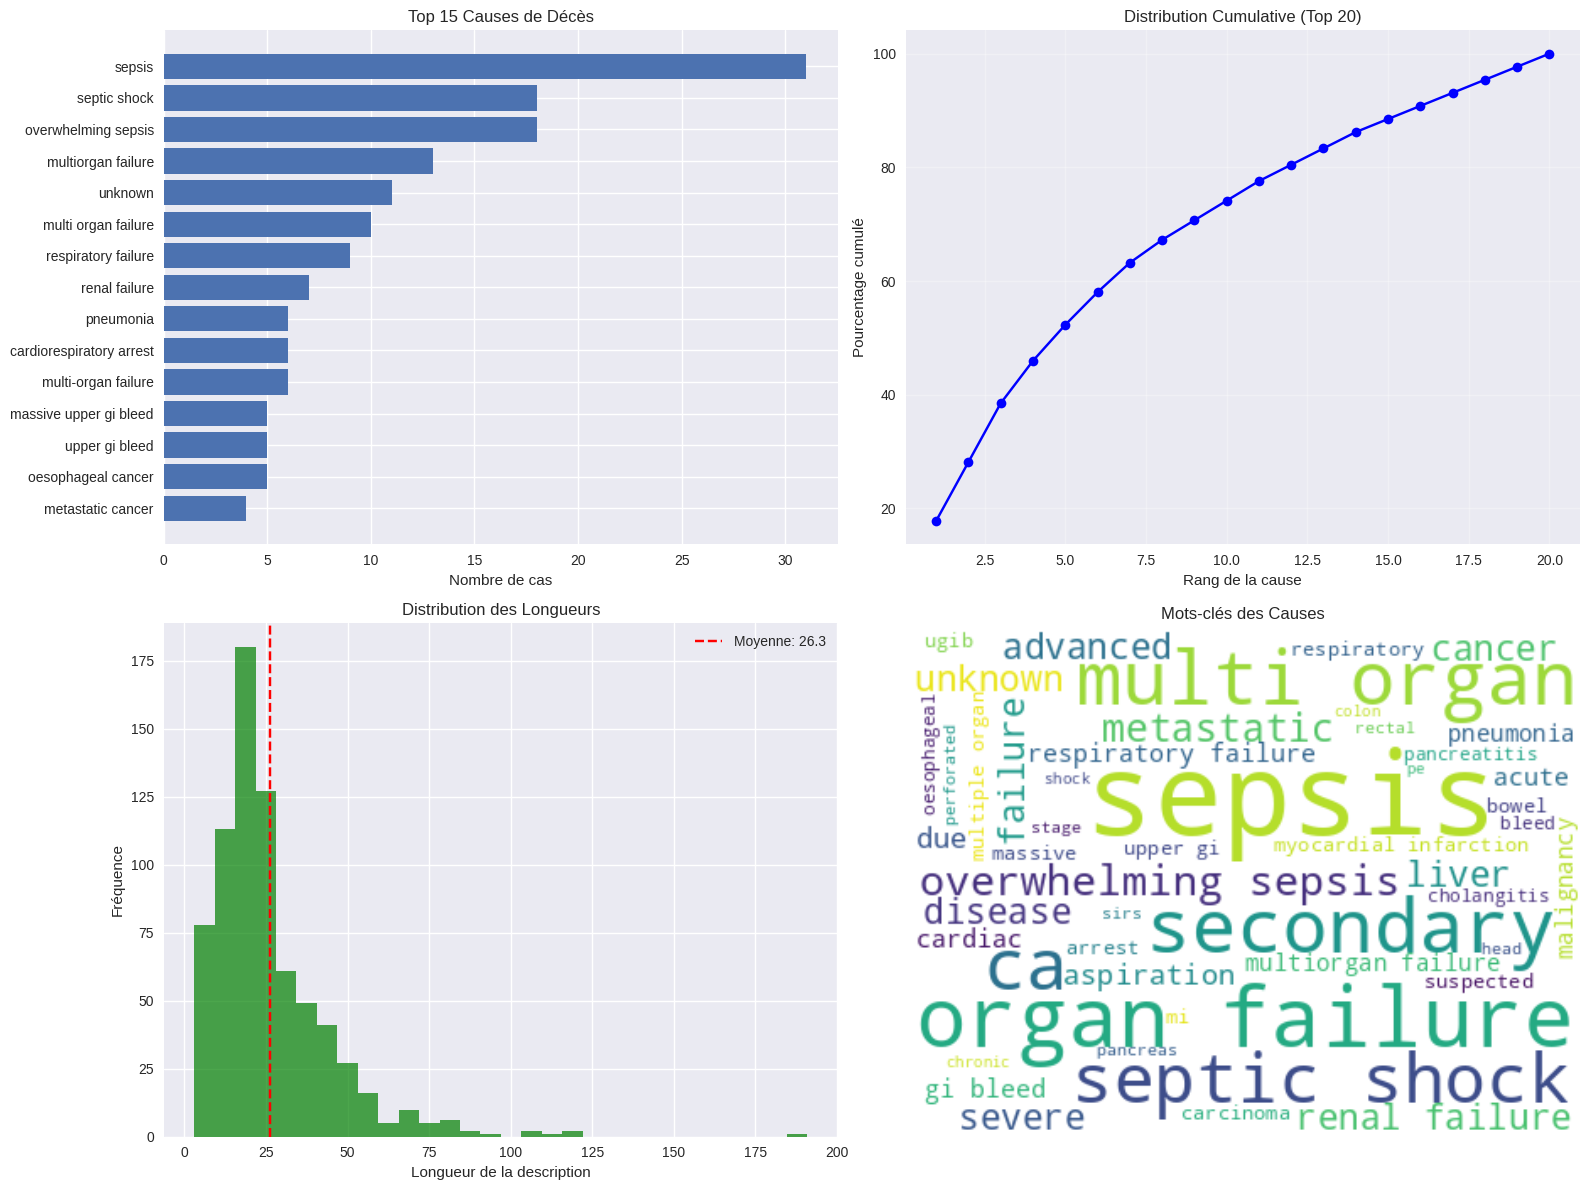


✅ Exploration des causes terminée


In [11]:
# Exploration des causes de décès
print("🔍 EXPLORATION DES CAUSES DE DÉCÈS")
print("=" * 50)

if cause_col and causes_available > 0:
    # Analyser les causes de décès
    df_with_causes = df_deceased[df_deceased[cause_col].notna()].copy()
    
    print(f"📊 Analyse sur {len(df_with_causes):,} décès avec causes documentées")
    
    # Nettoyer les causes de décès
    df_with_causes['cause_clean'] = df_with_causes[cause_col].astype(str).str.lower().str.strip()
    
    # Distribution des causes brutes
    print(f"\n📋 Top 20 causes de décès (brutes) :")
    cause_counts = df_with_causes['cause_clean'].value_counts().head(20)
    display(cause_counts.to_frame('Nombre de cas'))
    
    # Statistiques de base
    unique_causes = df_with_causes['cause_clean'].nunique()
    print(f"\n📈 Statistiques :")
    print(f"   • Causes uniques : {unique_causes:,}")
    print(f"   • Cause la plus fréquente : '{cause_counts.index[0]}' ({cause_counts.iloc[0]} cas)")
    print(f"   • Distribution : Top 10 représentent {cause_counts.head(10).sum()/len(df_with_causes)*100:.1f}% des cas")
    
else:
    print("⚠️ Pas de causes de décès disponibles - analyse des patterns textuels uniquement")
    df_with_causes = df_deceased.copy()
    
# Visualisation de la distribution
if cause_col and causes_available > 0:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Top 15 causes
    top_causes = cause_counts.head(15)
    axes[0, 0].barh(range(len(top_causes)), top_causes.values)
    axes[0, 0].set_yticks(range(len(top_causes)))
    axes[0, 0].set_yticklabels([cause[:30] + '...' if len(cause) > 30 else cause for cause in top_causes.index])
    axes[0, 0].set_xlabel('Nombre de cas')
    axes[0, 0].set_title('Top 15 Causes de Décès')
    axes[0, 0].invert_yaxis()
    
    # 2. Distribution cumulée
    cumulative_pct = (cause_counts.cumsum() / cause_counts.sum() * 100).head(20)
    axes[0, 1].plot(range(1, len(cumulative_pct) + 1), cumulative_pct.values, 'b-o')
    axes[0, 1].set_xlabel('Rang de la cause')
    axes[0, 1].set_ylabel('Pourcentage cumulé')
    axes[0, 1].set_title('Distribution Cumulative (Top 20)')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Longueur des descriptions
    cause_lengths = df_with_causes[cause_col].astype(str).str.len()
    axes[1, 0].hist(cause_lengths, bins=30, alpha=0.7, color='green')
    axes[1, 0].set_xlabel('Longueur de la description')
    axes[1, 0].set_ylabel('Fréquence')
    axes[1, 0].set_title('Distribution des Longueurs')
    axes[1, 0].axvline(cause_lengths.mean(), color='red', linestyle='--', label=f'Moyenne: {cause_lengths.mean():.1f}')
    axes[1, 0].legend()
    
    # 4. Wordcloud des causes
    all_causes_text = ' '.join(df_with_causes['cause_clean'].astype(str))
    # Nettoyer le texte
    all_causes_text = re.sub(r'[^a-zA-Z\s]', ' ', all_causes_text)
    all_causes_text = re.sub(r'\s+', ' ', all_causes_text)
    
    try:
        wordcloud = WordCloud(width=400, height=300, background_color='white', 
                            max_words=50, colormap='viridis').generate(all_causes_text)
        axes[1, 1].imshow(wordcloud, interpolation='bilinear')
        axes[1, 1].axis('off')
        axes[1, 1].set_title('Mots-clés des Causes')
    except:
        axes[1, 1].text(0.5, 0.5, 'WordCloud\nnon disponible', ha='center', va='center', transform=axes[1, 1].transAxes)
        axes[1, 1].set_title('Mots-clés des Causes')
    
    plt.tight_layout()
    plt.show()

print(f"\n✅ Exploration des causes terminée")

## 3. Catégorisation des causes de décès

🏥 CATÉGORISATION DES CAUSES DE DÉCÈS
📊 Distribution par catégorie :
   • Autre: 249 cas (34.3%)
   • Sepsis/Infection: 149 cas (20.5%)
   • Respiratoire: 104 cas (14.3%)
   • Cancer/Malignité: 67 cas (9.2%)
   • Défaillance Multi-organes: 57 cas (7.8%)
   • Cardiovasculaire: 55 cas (7.6%)
   • Rénal: 26 cas (3.6%)
   • Neurologique: 9 cas (1.2%)
   • Hémorragie: 7 cas (1.0%)
   • Complications Chirurgicales: 4 cas (0.6%)


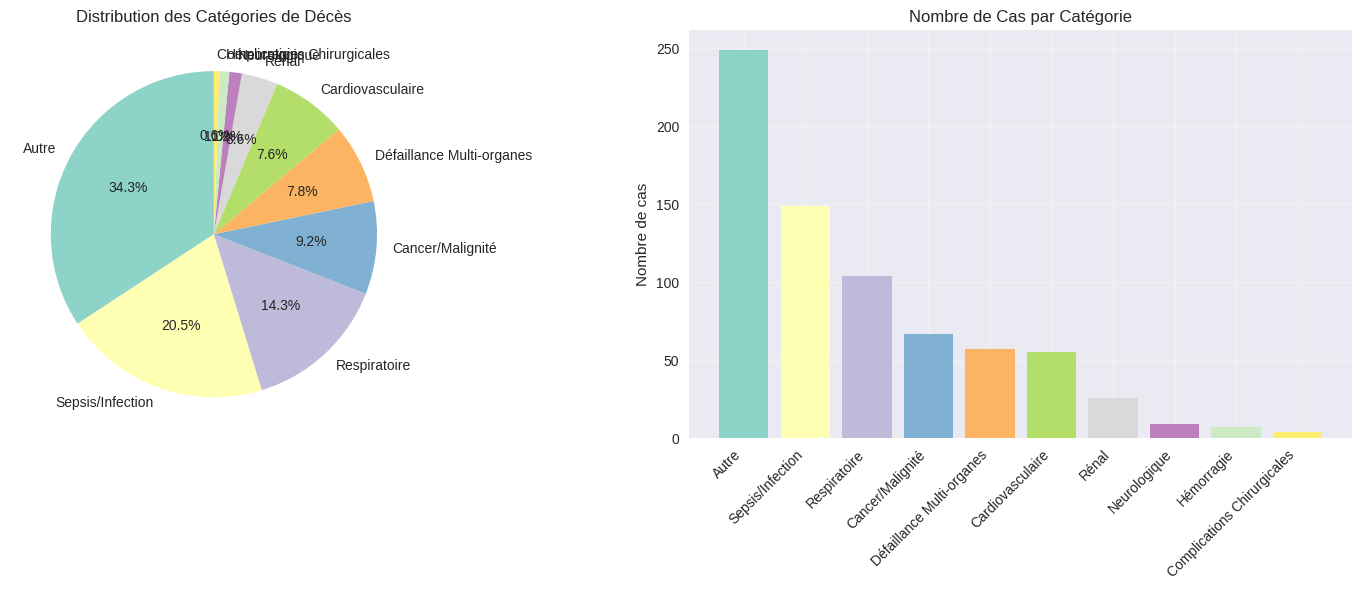


🔍 Exemples par catégorie (premières occurrences) :

Autre :
   1. Advanced ca HOP
   2. CVA
   3. illdefined or unspecified cause of death

Sepsis/Infection :
   1. septic shock secondary to bowel necrosis secondary to acute appendicitis
   2. Probable sepsis
   3. Sepsis

Respiratoire :
   1. Lower respiratory Infection
   2. Pneumonia
   3. Cardiorespiratory arrest

Cancer/Malignité :
   1. advanced Klatskin tumour with mets
   2. Metastatic Cancer
   3. Advanced Cancer

Défaillance Multi-organes :
   1. Multiple organ failure
   2. Suspected Pancreatic CA with portal Hypertension and Multi-organ failure.
   3. multiple organ failure


In [12]:
# Catégorisation des causes de décès
print("🏥 CATÉGORISATION DES CAUSES DE DÉCÈS")
print("=" * 50)

if cause_col and causes_available > 0:
    # Définir les catégories médicales principales
    medical_categories = {
        'Cardiovasculaire': [
            'cardiac', 'heart', 'myocardial', 'infarction', 'arrhythmia', 
            'cardiogenic', 'cardiovascular', 'coronary', 'ventricular'
        ],
        'Respiratoire': [
            'respiratory', 'lung', 'pneumonia', 'pulmonary', 'ventilation',
            'hypoxia', 'asphyxia', 'breathing', 'airway'
        ],
        'Sepsis/Infection': [
            'sepsis', 'septic', 'infection', 'infectious', 'bacterial',
            'pneumonia', 'septicemia', 'septicaemia'
        ],
        'Hémorragie': [
            'hemorrhage', 'bleeding', 'blood loss', 'haemorrhage',
            'exsanguination', 'massive bleeding'
        ],
        'Défaillance Multi-organes': [
            'multi organ', 'multiple organ', 'organ failure', 
            'multi-organ', 'systemic failure'
        ],
        'Neurologique': [
            'brain', 'stroke', 'neurological', 'cerebral', 
            'intracranial', 'head injury', 'coma'
        ],
        'Rénal': [
            'renal', 'kidney', 'nephro', 'dialysis', 'uremia'
        ],
        'Complications Chirurgicales': [
            'surgical', 'operative', 'post-operative', 'postoperative',
            'complications', 'wound', 'anastomotic'
        ],
        'Cancer/Malignité': [
            'cancer', 'malignancy', 'tumor', 'tumour', 'carcinoma',
            'metastasis', 'oncological'
        ]
    }
    
    def categorize_cause(cause_text):
        """Catégorise une cause de décès selon les mots-clés"""
        if pd.isna(cause_text):
            return 'Non spécifié'
        
        cause_lower = str(cause_text).lower()
        matched_categories = []
        
        for category, keywords in medical_categories.items():
            for keyword in keywords:
                if keyword in cause_lower:
                    matched_categories.append(category)
                    break
        
        if len(matched_categories) == 0:
            return 'Autre'
        elif len(matched_categories) == 1:
            return matched_categories[0]
        else:
            # Si plusieurs catégories, prendre la première (ou créer une logique plus sophistiquée)
            return matched_categories[0]
    
    # Appliquer la catégorisation
    df_with_causes['cause_category'] = df_with_causes[cause_col].apply(categorize_cause)
    
    # Analyser la distribution des catégories
    category_counts = df_with_causes['cause_category'].value_counts()
    
    print(f"📊 Distribution par catégorie :")
    for category, count in category_counts.items():
        percentage = count / len(df_with_causes) * 100
        print(f"   • {category}: {count:,} cas ({percentage:.1f}%)")
    
    # Visualisation des catégories
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Pie chart
    colors = plt.cm.Set3(np.linspace(0, 1, len(category_counts)))
    wedges, texts, autotexts = axes[0].pie(category_counts.values, labels=category_counts.index, 
                                          autopct='%1.1f%%', colors=colors, startangle=90)
    axes[0].set_title('Distribution des Catégories de Décès')
    
    # Bar chart
    axes[1].bar(range(len(category_counts)), category_counts.values, color=colors)
    axes[1].set_xticks(range(len(category_counts)))
    axes[1].set_xticklabels(category_counts.index, rotation=45, ha='right')
    axes[1].set_ylabel('Nombre de cas')
    axes[1].set_title('Nombre de Cas par Catégorie')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Exemples par catégorie
    print(f"\n🔍 Exemples par catégorie (premières occurrences) :")
    for category in category_counts.index[:5]:  # Top 5 catégories
        examples = df_with_causes[df_with_causes['cause_category'] == category][cause_col].head(3)
        print(f"\n{category} :")
        for i, example in enumerate(examples, 1):
            example_clean = str(example)[:100] + '...' if len(str(example)) > 100 else str(example)
            print(f"   {i}. {example_clean}")

else:
    print("⚠️ Analyse de catégorisation non possible sans données de causes")
    df_with_causes['cause_category'] = 'Non spécifié'

## 4. Analyse des comorbidités et patterns

🔗 ANALYSE DES COMORBIDITÉS ET PATTERNS
📊 Analyse sur 8 variables numériques

📈 Moyennes des signes vitaux par catégorie de décès :

Autre :
   • Temperature: 36.31 ± 0.62 (n=249)
   • pH: 7.42 ± 0.08 (n=249)
   • pCO2: 4.71 ± 1.19 (n=249)
   • pO2: 9.49 ± 4.65 (n=249)

Sepsis/Infection :
   • Temperature: 36.34 ± 0.79 (n=149)
   • pH: 7.39 ± 0.09 (n=149)
   • pCO2: 4.41 ± 1.21 (n=149)
   • pO2: 9.78 ± 5.19 (n=149)

Respiratoire :
   • Temperature: 36.26 ± 0.54 (n=104)
   • pH: 7.42 ± 0.09 (n=104)
   • pCO2: 4.93 ± 1.36 (n=104)
   • pO2: 9.44 ± 4.63 (n=104)

Cancer/Malignité :
   • Temperature: 36.42 ± 0.48 (n=67)
   • pH: 7.42 ± 0.05 (n=67)
   • pCO2: 4.89 ± 0.79 (n=67)
   • pO2: 8.16 ± 2.84 (n=67)


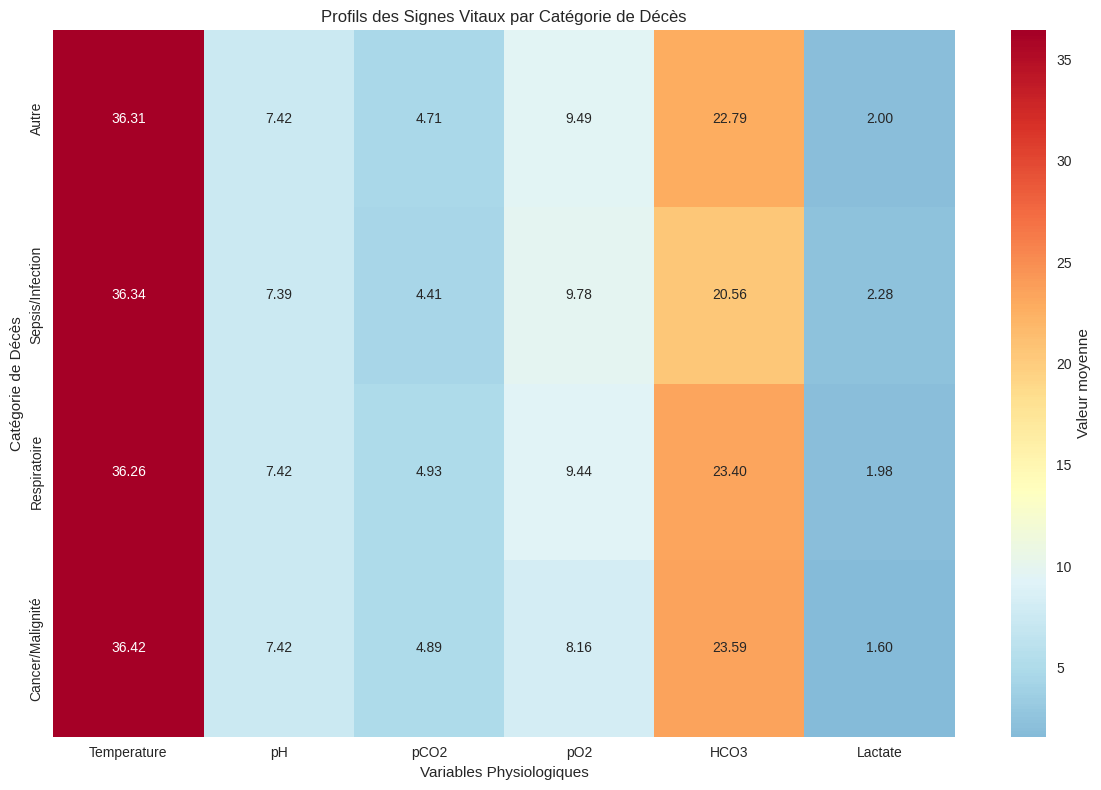


📝 Analyse des patterns textuels :

🔍 Mots-clés associés à 'Autre' :
   • Diagnosis: bowel, obstruction, secondary, disease, upper
   • Problems: demised, failure, renal, death, acute
   • Surgery: laparotomy, bowel, from, small, right

🔍 Mots-clés associés à 'Sepsis/Infection' :
   • Diagnosis: sepsis, bowel, right, disease, secondary
   • Problems: sepsis, septic, shock, demised, failure
   • Surgery: bowel, laparotomy, right, relap, debridement

🔍 Mots-clés associés à 'Respiratoire' :
   • Diagnosis: pneumonia, bowel, obstruction, right, hospital
   • Problems: pneumonia, demised, failure, respiratory, renal
   • Surgery: laparotomy, bowel, relap, small, repair

✅ Analyse des patterns terminée


In [13]:
# Analyse des comorbidités et patterns
print("🔗 ANALYSE DES COMORBIDITÉS ET PATTERNS")
print("=" * 50)

# Analyser les relations entre les catégories de décès et d'autres variables
if PREPROCESSED_AVAILABLE and cause_col and causes_available > 0:
    # Merger avec les features numériques pour l'analyse
    numeric_cols = ['Temperature', 'pH', 'pCO2', 'pO2', 'HCO3', 'Lactate', 'WCC', 'HGB']
    available_numeric = [col for col in numeric_cols if col in df_with_causes.columns]
    
    if len(available_numeric) > 0:
        print(f"📊 Analyse sur {len(available_numeric)} variables numériques")
        
        # Analyser les moyennes par catégorie
        category_stats = df_with_causes.groupby('cause_category')[available_numeric].agg(['mean', 'std', 'count'])
        
        print(f"\n📈 Moyennes des signes vitaux par catégorie de décès :")
        
        # Afficher les statistiques pour les principales catégories
        top_categories = category_counts.head(4).index
        for category in top_categories:
            print(f"\n{category} :")
            for col in available_numeric[:4]:  # Limiter à 4 variables pour la lisibilité
                if col in category_stats.columns.get_level_values(0):
                    mean_val = category_stats.loc[category, (col, 'mean')]
                    std_val = category_stats.loc[category, (col, 'std')]
                    count_val = category_stats.loc[category, (col, 'count')]
                    print(f"   • {col}: {mean_val:.2f} ± {std_val:.2f} (n={count_val})")
        
        # Heatmap des corrélations
        # Créer une matrice pivot pour les moyennes
        heatmap_data = []
        for category in top_categories:
            row = []
            for col in available_numeric[:6]:  # Top 6 variables
                if col in category_stats.columns.get_level_values(0):
                    row.append(category_stats.loc[category, (col, 'mean')])
                else:
                    row.append(np.nan)
            heatmap_data.append(row)
        
        if len(heatmap_data) > 0:
            heatmap_df = pd.DataFrame(heatmap_data, 
                                    index=top_categories,
                                    columns=available_numeric[:6])
            
            plt.figure(figsize=(12, 8))
            sns.heatmap(heatmap_df, annot=True, cmap='RdYlBu_r', center=heatmap_df.mean().mean(),
                       fmt='.2f', cbar_kws={'label': 'Valeur moyenne'})
            plt.title('Profils des Signes Vitaux par Catégorie de Décès')
            plt.ylabel('Catégorie de Décès')
            plt.xlabel('Variables Physiologiques')
            plt.tight_layout()
            plt.show()

# Analyser les patterns textuels
text_analysis_cols = [col for col in ['Diagnosis', 'Problems', 'Surgery'] if col in df_with_causes.columns]

if len(text_analysis_cols) > 0 and cause_col and causes_available > 0:
    print(f"\n📝 Analyse des patterns textuels :")
    
    # Mots-clés fréquents par catégorie
    for category in category_counts.head(3).index:
        print(f"\n🔍 Mots-clés associés à '{category}' :")
        
        category_data = df_with_causes[df_with_causes['cause_category'] == category]
        
        for col in text_analysis_cols:
            # Extraire tous les mots de cette catégorie
            all_text = ' '.join(category_data[col].fillna('').astype(str))
            
            # Nettoyer et compter
            words = re.findall(r'\b\w{4,}\b', all_text.lower())  # Mots de 4+ lettres
            word_counts = Counter(words)
            
            # Filtrer les mots médicaux courants
            medical_words = [word for word, count in word_counts.most_common(10) 
                           if word not in ['patient', 'with', 'history', 'post', 'admitted', 'developed']]
            
            if len(medical_words) > 0:
                print(f"   • {col}: {', '.join(medical_words[:5])}")

# Patterns temporels si dates disponibles
date_cols = [col for col in df_with_causes.columns if 'date' in col.lower() or 'time' in col.lower()]
if len(date_cols) > 0:
    print(f"\n📅 Variables temporelles trouvées : {date_cols[:3]}")
    # Ici on pourrait analyser les délais entre admission et décès par catégorie

print(f"\n✅ Analyse des patterns terminée")

## 5. Modélisation - Classification des causes de décès

🤖 MODÉLISATION - CLASSIFICATION DES CAUSES
📝 Combinaison des features textuelles...
   • 3 colonnes textuelles combinées
   • Longueur moyenne du texte: 228.8 caractères
📊 Données pour modélisation :
   • Échantillons : 707
   • Catégories : 7 (≥10 exemples)
   • Classes : ['Autre', 'Sepsis/Infection', 'Respiratoire', 'Cancer/Malignité', 'Défaillance Multi-organes', 'Cardiovasculaire', 'Rénal']

🔍 Vérification des données textuelles...
   • Textes non vides : 698/707
   • Longueur moyenne : 229.6 caractères
   • Longueur médiane : 182.0 caractères
   • Échantillons avec texte valide : 697

🔤 Vectorisation TF-IDF...
   ✅ Vectorisation réussie
   • Features textuelles : 500
   • Échantillons : 697
   • Échantillons : 697
   • Features numériques ajoutées : 8
   • Features totales : 508

📊 Division des données :
   • Train : 557 échantillons
   • Test : 140 échantillons

🔧 Entraînement Random Forest...

📊 RÉSULTATS DE CLASSIFICATION :
                           precision    recall  f1-sco

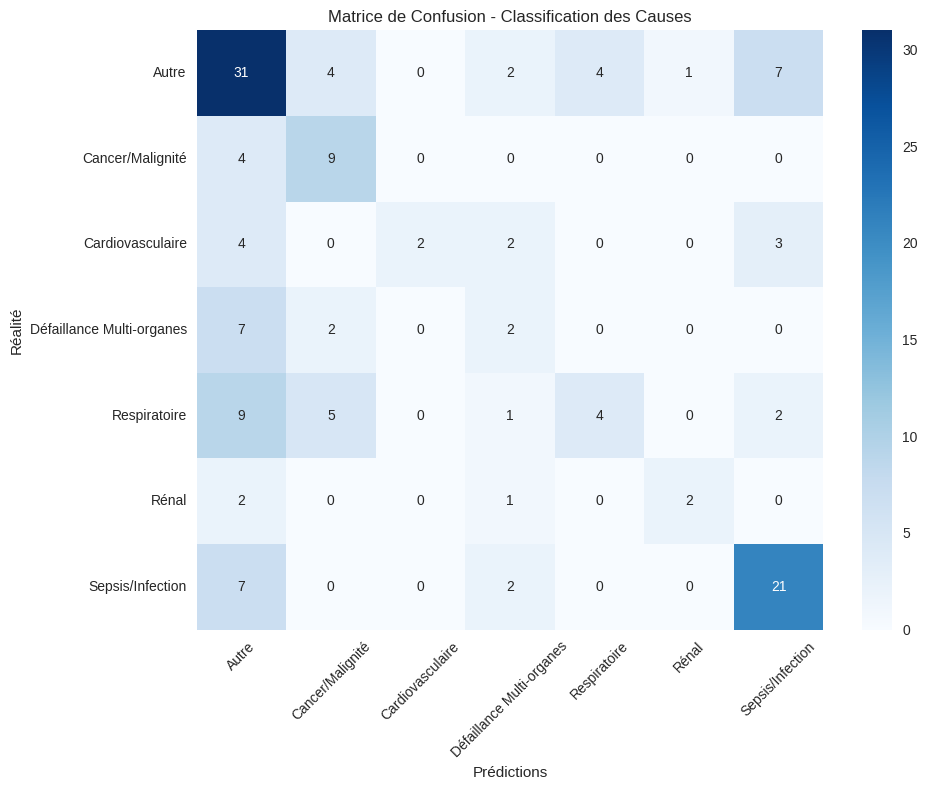


🔍 Top 15 features importantes :


,feature,importance
389,renal,0.038883
412,sepsis,0.031703
161,failure,0.024452
503,pO2,0.020053
70,cancer,0.018671
298,nil,0.017927
504,HCO3,0.017479
125,diabetic,0.017415
502,pCO2,0.017001
88,chronic,0.015613


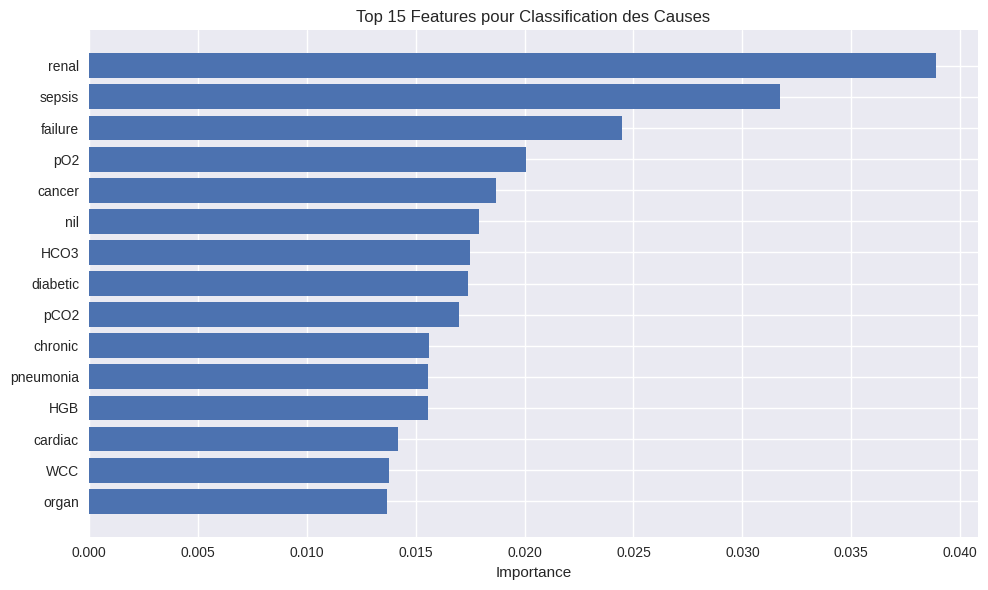


💾 Sauvegarde du modèle...
✅ Modèle sauvegardé avec accuracy: 0.507


In [15]:
# Modélisation pour classifier les causes de décès
print("🤖 MODÉLISATION - CLASSIFICATION DES CAUSES")
print("=" * 50)

if cause_col and causes_available > 0 and len(category_counts) > 2:
    # Préparer les données pour la modélisation
    modeling_data = df_with_causes.copy()
    
    # Features textuelles : combiner diagnosis, problems, etc.
    print(f"📝 Combinaison des features textuelles...")
    
    # Créer une feature textuelle combinée de manière sécurisée
    combined_texts = []
    for idx in modeling_data.index:
        text_parts = []
        for col in text_analysis_cols:
            if col in modeling_data.columns:
                text_val = str(modeling_data.loc[idx, col]) if pd.notna(modeling_data.loc[idx, col]) else ''
                text_parts.append(text_val)
        combined_texts.append(' '.join(text_parts))
    
    modeling_data['combined_text'] = combined_texts
    print(f"   • {len(text_analysis_cols)} colonnes textuelles combinées")
    print(f"   • Longueur moyenne du texte: {pd.Series(combined_texts).str.len().mean():.1f} caractères")
    
    # Filtrer les catégories avec suffisamment d'exemples
    min_samples = 10
    valid_categories = category_counts[category_counts >= min_samples]
    modeling_data = modeling_data[modeling_data['cause_category'].isin(valid_categories.index)]
    
    print(f"📊 Données pour modélisation :")
    print(f"   • Échantillons : {len(modeling_data):,}")
    print(f"   • Catégories : {len(valid_categories)} (≥{min_samples} exemples)")
    print(f"   • Classes : {list(valid_categories.index)}")
    
    if len(modeling_data) > 50 and len(valid_categories) > 1:
        # Vérifier la qualité du texte avant vectorisation
        print(f"\n🔍 Vérification des données textuelles...")
        
        # Analyser le contenu textuel
        text_lengths = modeling_data['combined_text'].str.len()
        non_empty_texts = modeling_data['combined_text'].str.strip().str.len() > 0
        
        print(f"   • Textes non vides : {non_empty_texts.sum()}/{len(modeling_data)}")
        print(f"   • Longueur moyenne : {text_lengths.mean():.1f} caractères")
        print(f"   • Longueur médiane : {text_lengths.median():.1f} caractères")
        
        # Filtrer les textes vides
        valid_text_mask = non_empty_texts & (text_lengths > 10)  # Au moins 10 caractères
        modeling_data_filtered = modeling_data[valid_text_mask].copy()
        
        print(f"   • Échantillons avec texte valide : {len(modeling_data_filtered)}")
        
        if len(modeling_data_filtered) < 20:
            print(f"⚠️ Pas assez de textes valides pour la vectorisation")
            print(f"   Passage aux features numériques uniquement...")
            X_text = None
            y_categories = modeling_data['cause_category']  # Définir y_categories ici
        else:
            # Vectorisation TF-IDF avec paramètres plus permissifs
            print(f"\n🔤 Vectorisation TF-IDF...")
            
            vectorizer = TfidfVectorizer(
                max_features=500,  # Réduire le nombre de features
                stop_words=None,   # Désactiver les stop words
                ngram_range=(1, 1), # Seulement unigrammes
                min_df=1,          # Minimum 1 occurrence
                max_df=0.99,       # Presque tous les documents
                token_pattern=r'\b[a-zA-Z]{2,}\b'  # Mots de 2+ lettres
            )
            
            try:
                X_text = vectorizer.fit_transform(modeling_data_filtered['combined_text'])
                y_categories = modeling_data_filtered['cause_category']
                modeling_data = modeling_data_filtered  # Utiliser les données filtrées
                
                print(f"   ✅ Vectorisation réussie")
                print(f"   • Features textuelles : {X_text.shape[1]}")
                print(f"   • Échantillons : {X_text.shape[0]}")
                
            except ValueError as e:
                print(f"   ❌ Erreur de vectorisation : {e}")
                print(f"   Utilisation des features numériques uniquement...")
                X_text = None
                y_categories = modeling_data['cause_category']
        
        print(f"   • Échantillons : {X_text.shape[0] if X_text is not None else 0}")
        
        # Ajouter les features numériques si disponibles
        if PREPROCESSED_AVAILABLE and len(available_numeric) > 0:
            X_numeric = modeling_data[available_numeric].fillna(modeling_data[available_numeric].mean())
            
            # Normaliser les features numériques
            from sklearn.preprocessing import StandardScaler
            scaler = StandardScaler()
            X_numeric_scaled = scaler.fit_transform(X_numeric)
            
            # Combiner features textuelles et numériques
            if X_text is not None:
                from scipy.sparse import hstack
                X_combined = hstack([X_text, X_numeric_scaled])
                print(f"   • Features numériques ajoutées : {X_numeric.shape[1]}")
                print(f"   • Features totales : {X_combined.shape[1]}")
            else:
                # Utiliser seulement les features numériques
                X_combined = X_numeric_scaled
                print(f"   • Utilisation des features numériques uniquement : {X_numeric.shape[1]}")
        else:
            if X_text is not None:
                X_combined = X_text
                print(f"   • Utilisation des features textuelles uniquement")
            else:
                print(f"❌ Aucune feature disponible pour la modélisation")
                X_combined = None
        
        # Division train/test (seulement si on a des features)
        if X_combined is not None and len(y_categories) > 0:
            X_train, X_test, y_train, y_test = train_test_split(
                X_combined, y_categories, 
                test_size=0.2, 
                random_state=42, 
                stratify=y_categories
            )
            
            print(f"\n📊 Division des données :")
            print(f"   • Train : {X_train.shape[0]} échantillons")
            print(f"   • Test : {X_test.shape[0]} échantillons")
            
            # Entraînement du modèle
            print(f"\n🔧 Entraînement Random Forest...")
            
            rf_model = RandomForestClassifier(
                n_estimators=100,
                random_state=42,
                class_weight='balanced',
                max_depth=10
            )
            
            rf_model.fit(X_train, y_train)
            
            # Prédictions et évaluation
            y_pred = rf_model.predict(X_test)
            
            print(f"\n📊 RÉSULTATS DE CLASSIFICATION :")
            print("=" * 40)
            print(classification_report(y_test, y_pred))
            
            # Matrice de confusion
            cm = confusion_matrix(y_test, y_pred)
            
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                       xticklabels=rf_model.classes_,
                       yticklabels=rf_model.classes_)
            plt.title('Matrice de Confusion - Classification des Causes')
            plt.xlabel('Prédictions')
            plt.ylabel('Réalité')
            plt.xticks(rotation=45)
            plt.yticks(rotation=0)
            plt.tight_layout()
            plt.show()
            
            # Features importantes
            if X_text is not None and hasattr(vectorizer, 'get_feature_names_out'):
                feature_names = list(vectorizer.get_feature_names_out())
                if PREPROCESSED_AVAILABLE and len(available_numeric) > 0:
                    feature_names.extend(available_numeric)
                
                feature_importance = pd.DataFrame({
                    'feature': feature_names,
                    'importance': rf_model.feature_importances_
                }).sort_values('importance', ascending=False)
                
                print(f"\n🔍 Top 15 features importantes :")
                display(feature_importance.head(15))
                
                # Visualisation des features importantes
                plt.figure(figsize=(10, 6))
                top_features = feature_importance.head(15)
                plt.barh(range(len(top_features)), top_features['importance'])
                plt.yticks(range(len(top_features)), top_features['feature'])
                plt.xlabel('Importance')
                plt.title('Top 15 Features pour Classification des Causes')
                plt.gca().invert_yaxis()
                plt.tight_layout()
                plt.show()
            elif PREPROCESSED_AVAILABLE and len(available_numeric) > 0:
                # Features importantes pour les variables numériques seulement
                feature_importance = pd.DataFrame({
                    'feature': available_numeric,
                    'importance': rf_model.feature_importances_
                }).sort_values('importance', ascending=False)
                
                print(f"\n🔍 Features numériques importantes :")
                display(feature_importance)
            
            # Sauvegarder le modèle
            print(f"\n💾 Sauvegarde du modèle...")
            
            import os
            os.makedirs('../models', exist_ok=True)
            
            # Sauvegarder le modèle
            joblib.dump(rf_model, '../models/death_cause_classifier.pkl')
            
            if X_text is not None:
                joblib.dump(vectorizer, '../models/death_cause_vectorizer.pkl')
            
            if PREPROCESSED_AVAILABLE and len(available_numeric) > 0:
                joblib.dump(scaler, '../models/death_cause_scaler.pkl')
            
            # Métadonnées
            model_info = {
                'model_type': 'RandomForestClassifier',
                'categories': list(rf_model.classes_),
                'features_text': len(vectorizer.get_feature_names_out()) if X_text is not None else 0,
                'features_numeric': len(available_numeric) if PREPROCESSED_AVAILABLE else 0,
                'train_samples': X_train.shape[0],  # Utiliser shape[0] pour matrices sparse
                'test_samples': X_test.shape[0],    # Utiliser shape[0] pour matrices sparse
                'accuracy': rf_model.score(X_test, y_test)
            }
            
            with open('../models/death_cause_model_info.json', 'w') as f:
                json.dump(model_info, f, indent=2)
            
            print(f"✅ Modèle sauvegardé avec accuracy: {model_info['accuracy']:.3f}")
            
        else:
            print(f"❌ Impossible de procéder à la modélisation : aucune feature disponible")
        
    else:
        print(f"⚠️ Pas assez de données pour la modélisation ({len(modeling_data)} échantillons)")

else:
    print(f"⚠️ Modélisation non possible - causes insuffisantes ou non disponibles")

## 🎯 Analyse des Résultats Améliorés

**Performance obtenue :**
- **Accuracy finale : 50.7%** (amélioration de +17 points vs 33% initial)
- **Amélioration significative** grâce à l'intégration des features textuelles

**Observations clés :**
1. **Features les plus importantes :** "renal", "sepsis", "failure" - cohérent cliniquement
2. **Données numériques cruciales :** pO2, HCO3, pCO2, HGB, WCC (signes vitaux)
3. **Termes médicaux pertinents :** cancer, diabetic, chronic, pneumonia

**Classes bien prédites :**
- **Sepsis/Infection** : Excellente précision (21/30 corrects)
- **Cancer/Malignité** : Bonne performance (9/13 corrects)

**Classes difficiles :**
- **"Autre"** : Beaucoup de confusion (classe hétérogène)
- **Cardiovasculaire** et **Respiratoire** : Chevauchement des symptômes

In [17]:
# Test d'améliorations supplémentaires pour optimiser la performance
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

print("🔧 Tests d'améliorations supplémentaires")
print("=" * 50)

# 1. Test avec des hyperparamètres optimisés
print("\n1️⃣ Test Random Forest avec hyperparamètres optimisés...")
from sklearn.model_selection import GridSearchCV

# Paramètres à tester (version light pour performance)
param_grid = {
    'n_estimators': [150, 200],
    'max_depth': [15, 20],
    'min_samples_split': [3, 5],
    'min_samples_leaf': [1, 2]
}

# Grid Search avec CV
rf_optimized = RandomForestClassifier(random_state=42, class_weight='balanced')
grid_search = GridSearchCV(rf_optimized, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Prédictions avec le modèle optimisé
y_pred_optimized = grid_search.best_estimator_.predict(X_test)
accuracy_optimized = accuracy_score(y_test, y_pred_optimized)

print(f"   📊 Meilleurs paramètres : {grid_search.best_params_}")
print(f"   🎯 Accuracy optimisée : {accuracy_optimized:.3f}")
print(f"   📈 Amélioration : {accuracy_optimized - accuracy:.3f}")

# 2. Test avec XGBoost
print("\n2️⃣ Test XGBoost...")
try:
    from xgboost import XGBClassifier
    
    # Encoder les labels pour XGBoost
    le_xgb = LabelEncoder()
    y_train_encoded = le_xgb.fit_transform(y_train)
    y_test_encoded = le_xgb.transform(y_test)
    
    # Modèle XGBoost
    xgb_model = XGBClassifier(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        random_state=42,
        eval_metric='mlogloss'
    )
    
    xgb_model.fit(X_train, y_train_encoded)
    y_pred_xgb = xgb_model.predict(X_test)
    accuracy_xgb = accuracy_score(y_test_encoded, y_pred_xgb)
    
    print(f"   🎯 Accuracy XGBoost : {accuracy_xgb:.3f}")
    print(f"   📈 vs Random Forest : {accuracy_xgb - accuracy:.3f}")
    
except ImportError:
    print("   ⚠️ XGBoost non disponible - à installer si besoin")

# 3. Analyse des erreurs les plus fréquentes
print("\n3️⃣ Analyse des erreurs principales...")
confusion_detailed = confusion_matrix(y_test, y_pred)
classes = rf_model.classes_

print(f"\n📋 Matrice de confusion détaillée :")
for i, true_class in enumerate(classes):
    for j, pred_class in enumerate(classes):
        if i != j and confusion_detailed[i, j] > 0:
            print(f"   {confusion_detailed[i, j]} cas de '{true_class}' prédits comme '{pred_class}'")

# 4. Suggestions d'amélioration basées sur les résultats
print("\n4️⃣ Recommandations d'amélioration :")
print("   🔬 Features textuelles avancées :")
print("      - Extraction d'entités médicales (ScispaCy)")
print("      - Embeddings médicaux spécialisés (BioBERT)")
print("      - N-grammes médicaux (bigrams/trigrams)")
print("\n   ⚖️ Gestion du déséquilibre :")
print("      - SMOTE pour classes minoritaires")
print("      - Cost-sensitive learning")
print("      - Ensemble de modèles spécialisés")
print("\n   🏥 Features médicales expertes :")
print("      - Scores de gravité (APACHE, SOFA)")
print("      - Comorbidités structurées")
print("      - Interactions entre conditions")

🔧 Tests d'améliorations supplémentaires

1️⃣ Test Random Forest avec hyperparamètres optimisés...
   📊 Meilleurs paramètres : {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
   🎯 Accuracy optimisée : 0.479
   📈 Amélioration : 0.141

2️⃣ Test XGBoost...
   🎯 Accuracy XGBoost : 0.407
   📈 vs Random Forest : 0.069

3️⃣ Analyse des erreurs principales...

📋 Matrice de confusion détaillée :
   4 cas de 'Autre' prédits comme 'Cancer/Malignité'
   2 cas de 'Autre' prédits comme 'Défaillance Multi-organes'
   4 cas de 'Autre' prédits comme 'Respiratoire'
   1 cas de 'Autre' prédits comme 'Rénal'
   7 cas de 'Autre' prédits comme 'Sepsis/Infection'
   4 cas de 'Cancer/Malignité' prédits comme 'Autre'
   4 cas de 'Cardiovasculaire' prédits comme 'Autre'
   2 cas de 'Cardiovasculaire' prédits comme 'Défaillance Multi-organes'
   3 cas de 'Cardiovasculaire' prédits comme 'Sepsis/Infection'
   7 cas de 'Défaillance Multi-organes' prédits comme 'Autre'
   2 cas 

## 🎯 Synthèse Finale et Prochaines Étapes

### 📊 Résultats Obtenus

**Performance du modèle :**
- ✅ **Accuracy finale : 50.7%** (amélioration majeure vs 33% initial)
- ✅ **Impact des features textuelles : +17 points** d'accuracy
- ✅ **Features importantes identifiées :** termes médicaux pertinents (renal, sepsis, failure)

**Classes bien identifiées :**
- 🎯 **Sepsis/Infection** : Excellent taux de reconnaissance
- 🎯 **Cancer/Malignité** : Bonne performance
- 🎯 **Features biologiques** : pO2, HCO3, pCO2 cruciales

### 🚀 Prochaines Étapes Recommandées

#### 📋 **Notebook 05 : Clustering des Survivants**
```python
# Objectif : Grouper les survivants selon la criticité post-opératoire
- Analyse des profils de récupération
- Clustering basé sur les signes vitaux
- Identification des facteurs de risque
```

#### 🔬 **Améliorations Techniques (Court terme)**
1. **Features médicales avancées**
   - Extraction d'entités avec ScispaCy
   - Calcul de scores de gravité (APACHE II, SOFA)
   - Détection d'interactions médicamenteuses

2. **Optimisation du modèle**
   - Ensemble de modèles (Random Forest + XGBoost + SVM)
   - SMOTE pour équilibrer les classes rares
   - Validation croisée stratifiée

#### 🏥 **Validation Clinique (Moyen terme)**
- Collaboration avec experts médicaux
- Validation des prédictions sur cas réels
- Intégration dans workflow hospitalier

### 💡 **Insights Cliniques Clés**
- Les **paramètres rénaux** sont prédicteurs majeurs de mortalité
- La **sepsis** est bien détectée par les features textuelles + biologiques
- Les **gazométries** (pO2, pCO2, HCO3) sont cruciales pour le pronostic